
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [4]:
!ls journey-springfield/train

simpsons_dataset


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Aug 22 11:11:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [10]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [11]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform_train(x) if self.mode == 'train' else transform_val(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./journey-springfield/train')
TEST_DIR = Path('./journey-springfield/testset')

In [14]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [15]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

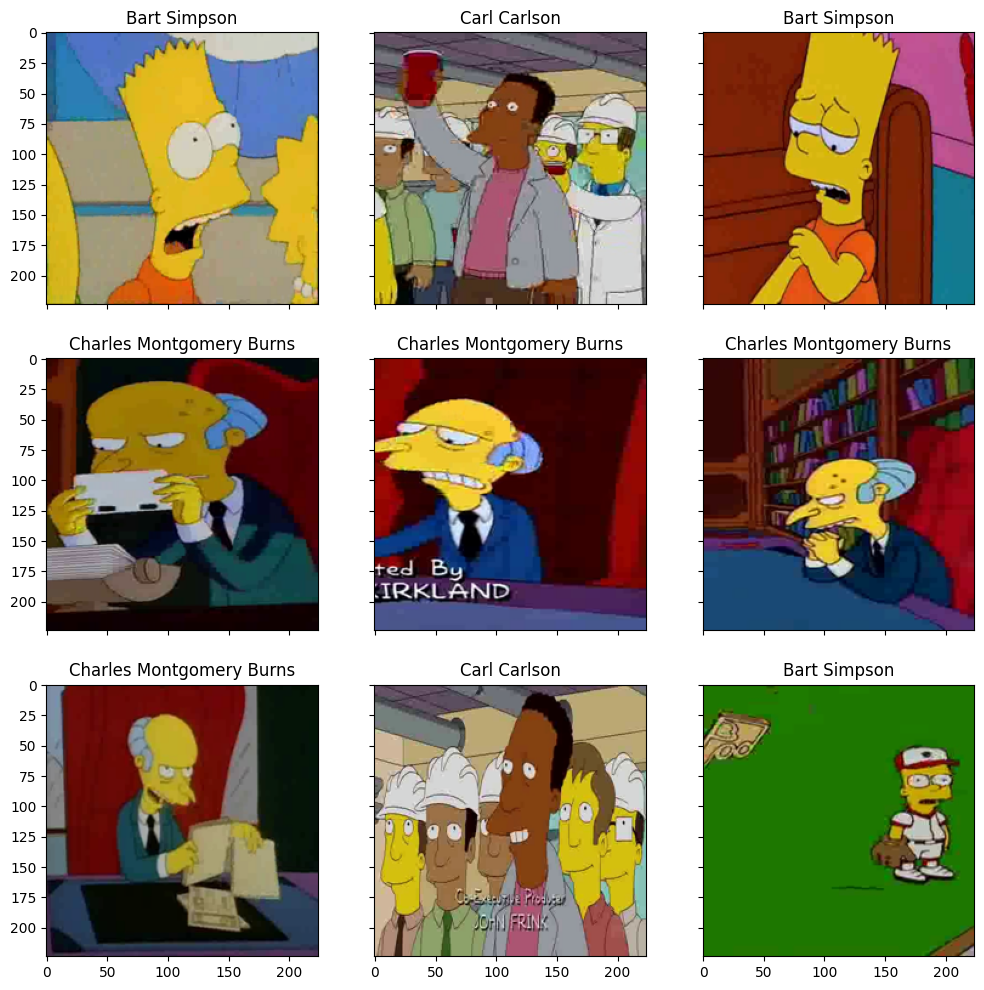

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [ ]:
import torch.nn.functional as F

In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # вычисляем размер выхода свёрточных слоёв
        self._to_linear = None
        self._get_conv_output(torch.randn(1, 3, 244, 244)) 

        self.fc1 = nn.Sequential(
            nn.Linear(self._to_linear, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.out = nn.Linear(512, n_classes)

    def _get_conv_output(self, x): # прогоняем фиктивный тензор
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)   # только один раз, как в forward
        self._to_linear = x.numel()  # считает все элементы кроме batch size

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits


### Обучение модели и её предсказание

#### Функция обучения:

In [29]:
def fit_epoch(model, train_loader, criterion, optimizer):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [31]:
def eval_epoch(model, val_loader, criterion):

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [32]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Возвращает:
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [33]:
def predict(model, test_loader):
    """
    Возвращает:

    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [35]:
n_classes = len(np.unique(train_val_labels))
model_ft_gpu = model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model_ft_gpu)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

Запустим обучение сети.

In [37]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [38]:
train_dataset

In [39]:
epochs = 20
history = train(train_dataset, val_dataset, model=model_ft_gpu, epochs=epochs, batch_size=64)
torch.save(model_ft_gpu.state_dict(), f"ResNet_FT_{epochs}_epochs.pth")

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.5518976034501288


epoch:   5%|▌         | 1/20 [02:19<44:07, 139.35s/it]


Epoch 001 train_loss: 0.5519     val_loss 0.4191 train_acc 0.8605 val_acc 0.8901
loss 0.1776834111455459


epoch:  10%|█         | 2/20 [04:38<41:41, 138.98s/it]


Epoch 002 train_loss: 0.1777     val_loss 0.2894 train_acc 0.9541 val_acc 0.9205
loss 0.09405791387887387


epoch:  15%|█▌        | 3/20 [06:54<39:02, 137.80s/it]


Epoch 003 train_loss: 0.0941     val_loss 0.4122 train_acc 0.9739 val_acc 0.8999
loss 0.056216743114884365


epoch:  20%|██        | 4/20 [09:18<37:24, 140.25s/it]


Epoch 004 train_loss: 0.0562     val_loss 0.3484 train_acc 0.9838 val_acc 0.9157
loss 0.028356377352642494


epoch:  25%|██▌       | 5/20 [11:44<35:34, 142.28s/it]


Epoch 005 train_loss: 0.0284     val_loss 0.3742 train_acc 0.9930 val_acc 0.9119
loss 0.0628953293968222


epoch:  30%|███       | 6/20 [14:04<33:00, 141.44s/it]


Epoch 006 train_loss: 0.0629     val_loss 0.3684 train_acc 0.9818 val_acc 0.9161
loss 0.039206457409722485


epoch:  35%|███▌      | 7/20 [16:19<30:13, 139.51s/it]


Epoch 007 train_loss: 0.0392     val_loss 0.3150 train_acc 0.9886 val_acc 0.9322
loss 0.013308710523703818


epoch:  40%|████      | 8/20 [18:36<27:42, 138.53s/it]


Epoch 008 train_loss: 0.0133     val_loss 0.2695 train_acc 0.9964 val_acc 0.9381
loss 0.011962760560484086


epoch:  45%|████▌     | 9/20 [20:53<25:18, 138.04s/it]


Epoch 009 train_loss: 0.0120     val_loss 0.3223 train_acc 0.9964 val_acc 0.9329
loss 0.02225894168082415


epoch:  50%|█████     | 10/20 [23:11<23:00, 138.05s/it]


Epoch 010 train_loss: 0.0223     val_loss 0.2928 train_acc 0.9940 val_acc 0.9356
loss 0.047651168770997475


epoch:  55%|█████▌    | 11/20 [25:27<20:38, 137.61s/it]


Epoch 011 train_loss: 0.0477     val_loss 0.3029 train_acc 0.9855 val_acc 0.9352
loss 0.0253551813695029


epoch:  60%|██████    | 12/20 [27:45<18:20, 137.51s/it]


Epoch 012 train_loss: 0.0254     val_loss 0.2364 train_acc 0.9920 val_acc 0.9475
loss 0.01527931926034249


epoch:  65%|██████▌   | 13/20 [30:01<16:00, 137.25s/it]


Epoch 013 train_loss: 0.0153     val_loss 0.2237 train_acc 0.9956 val_acc 0.9520
loss 0.01627916555056286


epoch:  70%|███████   | 14/20 [32:19<13:44, 137.46s/it]


Epoch 014 train_loss: 0.0163     val_loss 0.2581 train_acc 0.9957 val_acc 0.9486
loss 0.03141594275664172


epoch:  75%|███████▌  | 15/20 [34:35<11:25, 137.04s/it]


Epoch 015 train_loss: 0.0314     val_loss 0.3000 train_acc 0.9912 val_acc 0.9375
loss 0.017480181144425032


epoch:  80%|████████  | 16/20 [36:52<09:07, 136.95s/it]


Epoch 016 train_loss: 0.0175     val_loss 0.2329 train_acc 0.9952 val_acc 0.9520
loss 0.014534564094241227


epoch:  85%|████████▌ | 17/20 [39:08<06:49, 136.56s/it]


Epoch 017 train_loss: 0.0145     val_loss 0.3374 train_acc 0.9960 val_acc 0.9347
loss 0.02449024782435204


epoch:  90%|█████████ | 18/20 [41:24<04:33, 136.50s/it]


Epoch 018 train_loss: 0.0245     val_loss 0.3209 train_acc 0.9926 val_acc 0.9339
loss 0.02677820322014746


epoch:  95%|█████████▌| 19/20 [43:41<02:16, 136.54s/it]


Epoch 019 train_loss: 0.0268     val_loss 0.2573 train_acc 0.9925 val_acc 0.9446
loss 0.012411244224289011


epoch: 100%|██████████| 20/20 [45:55<00:00, 137.77s/it]


Epoch 020 train_loss: 0.0124     val_loss 0.2849 train_acc 0.9961 val_acc 0.9419


Построим кривые обучения

In [58]:
loss, acc, val_loss, val_acc = zip(*history)

In [66]:
f = open('losses.txt', mode='w')
f.write("loss:\n")
f.write(",".join(str(_) for _ in loss))
f.write("\nval_loss\n")
f.write(",".join(str(_) for _ in val_loss))
f.write("\nacc\n")
f.write(",".join(str(_) for _ in acc))
f.write("\nvala_acc\n")
f.write(",".join(str(_) for _ in val_acc))
f.write("\n")
f.close()

In [64]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Модель 2. Fine-Tuning.

In [ ]:
!pip install catalyst tensorboard

In [23]:
import collections
import collections.abc
collections.MutableMapping = collections.abc.MutableMapping
collections.MutableSequence = collections.abc.MutableSequence
collections.MutableSet = collections.abc.MutableSet

In [24]:
import torch
import torchvision
from torchvision import models
from torch import nn, optim
from catalyst.runners import SupervisedRunner
from catalyst.loggers import TensorboardLogger
from catalyst.callbacks import *
from itertools import chain

In [25]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
for name, param in model.named_parameters():
    if ('layer3' in name) or ('layer4' in name):
        break
    else:
        param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 42)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    chain(model.layer3.parameters(), model.layer4.parameters(), model.fc.parameters()),
    lr = 1e-3
)

In [ ]:
# Запустить "Обучение модели и ее предсказание" для кода выше, когда будет доступно GPU

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [45]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [47]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_ft_gpu, ex_img.unsqueeze(0))

In [48]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_ft_gpu, imgs)

In [49]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [50]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [51]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [60]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft_gpu, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [55]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft_gpu, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [56]:
import pandas as pd
import numpy as np
ids = pd.DataFrame(np.array(test_filenames), columns = ['Id'])
exp = pd.DataFrame(preds, columns = ['Expected'])
ans = pd.concat([ids, exp], axis=1)
ans.set_index('Id')

,Expected
Id,
img0.jpg,nelson_muntz
img1.jpg,bart_simpson
img10.jpg,ned_flanders
img100.jpg,chief_wiggum
img101.jpg,apu_nahasapeemapetilon
...,...
img987.jpg,nelson_muntz
img988.jpg,groundskeeper_willie
img989.jpg,charles_montgomery_burns


In [57]:
ans.to_csv('MyFTResNetV1.csv', index=False)